In [3]:
import numpy as np
import statsmodels.api as sm
from scipy.stats import f

def f_test(rss_restricted, rss_unrestricted, p, n, k):
    """
    Perform the F-test for comparing nested models.
    """
    F_statistic = ((rss_restricted - rss_unrestricted) / p) / (rss_unrestricted / (n - k - 1))
    df1 = p  # degrees of freedom for the numerator
    df2 = n - k - 1  # degrees of freedom for the denominator

    # calculates the p-value based on the F-distribution's cumulative distribution function (CDF)
    p_value = 1 - f.cdf(F_statistic, df1, df2)  
    
    return F_statistic, p_value

def granger_causality_test(y, x, max_lag):
    results = {}
    n = len(y)
    
    for lag in range(1, max_lag + 1):
        # Using the lagmat function from the statsmodels library to create a matrix of lagged values of the time series y.
        # y_lags, is a matrix where each column represents a lagged version of y, with the first column being y itself (due 
        # to original='in'), followed by columns for y lagged by 1 period, 2 periods, and so on, up to lag periods.
        y_lags = sm.tsa.lagmat(y, maxlag=lag, trim='both', original='in')

        # adds a column of ones to the matrix y_lags, which acts as the intercept term in the regression model.
        y_lags = sm.add_constant(y_lags)

        model_restricted = sm.OLS(y[lag:], y_lags).fit()
        rss_restricted = model_restricted.ssr

        x_lags = sm.tsa.lagmat(x, maxlag=lag, trim='both', original='in')
        combined_lags = np.hstack([y_lags, x_lags])
        model_unrestricted = sm.OLS(y[lag:], combined_lags).fit()
        rss_unrestricted = model_unrestricted.ssr

        k = combined_lags.shape[1]
        F_statistic, p_value = f_test(rss_restricted, rss_unrestricted, lag, n - lag, k)

        results[lag] = {'F-statistic': F_statistic, 'p-value': p_value}

    return results


In [7]:

y = np.random.randn(100)  # Replace with actual time series data
x = np.random.randn(100)  # Replace with actual time series data
max_lag = 4
results = granger_causality_test(y, x, max_lag)
print(results)


{1: {'F-statistic': -17.847674440985145, 'p-value': 1.0}, 2: {'F-statistic': 95.70614910829053, 'p-value': 1.1102230246251565e-16}, 3: {'F-statistic': -13.339182007731779, 'p-value': 1.0}, 4: {'F-statistic': -16.757175351434245, 'p-value': 1.0}}


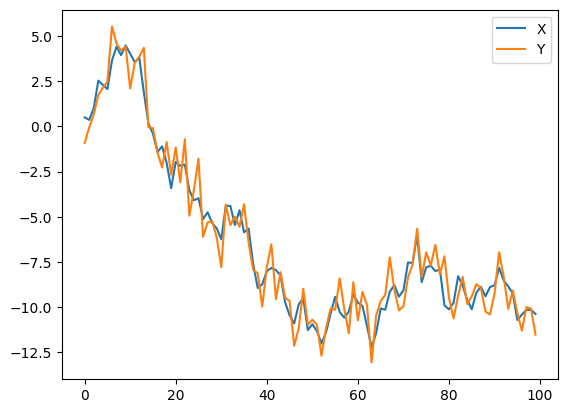

In [8]:
import numpy as np
import pandas as pd

# Set a seed for reproducibility
np.random.seed(42)

# Generate random time series data for two variables
n = 100  # Number of observations
x = np.random.normal(0, 1, n).cumsum()  # Cumulative sum to simulate a time series
y = x + np.random.normal(0, 1, n)  # y is influenced by x plus some noise

# Combine into a DataFrame
data = pd.DataFrame({'X': x, 'Y': y})

# plot the time series
import matplotlib.pyplot as plt
data.plot()
plt.show()

In [12]:
max_lag = 4
results = granger_causality_test(y, x, max_lag)
print(results)

{1: {'F-statistic': -30.08996564044037, 'p-value': 1.0}, 2: {'F-statistic': -40.266951314563556, 'p-value': 1.0}, 3: {'F-statistic': -4.057180304506864, 'p-value': 1.0}, 4: {'F-statistic': -19.46858024117597, 'p-value': 1.0}}


In [10]:
from statsmodels.tsa.stattools import grangercausalitytests

# All test results, dictionary keys are the number of lags. 
# For each lag the values are a tuple, with the first element 
# a dictionary with test statistic, pvalues, degrees of freedom, 
# the second element are the OLS estimation results for the restricted model, 
# the unrestricted model and the restriction (contrast) matrix for the parameter f_test.

gc_test_result = grangercausalitytests(data, maxlag=4, verbose=False)
gc_test_result

{1: ({'ssr_ftest': (1.8954996650231437, 0.17178525385790447, 96.0, 1),
   'ssr_chi2test': (1.9547340295551172, 0.16207762601062325, 1),
   'lrtest': (1.9356864436531396, 0.16413765972349692, 1),
   'params_ftest': (1.895499665023185, 0.17178525385790058, 96.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.9826320785226461, 0.37817673578150734, 93.0, 2),
   'ssr_chi2test': (2.0709235203272973, 0.35506238939845425, 2),
   'lrtest': (2.0493457309714245, 0.3589138593141429, 2),
   'params_ftest': (0.9826320785226788, 0.37817673578149746, 93.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.9813798739216825, 0.405236407034398, 90.0, 3),
   'ssr_chi2test': (3.1731282590134398, 0.3656947129976196, 3),
   'lrtest': (3.122332333866467, 0.37314580328923025, 3),
   'params_ftest': (0.981379873921683, 0.405236407034398, 90.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0.,